In [1]:
import torch
import torchvision
import os
from os.path import join as j_
from PIL import Image
import pandas as pd
import numpy as np

# loading all packages here to start
from uni import get_encoder
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe
from uni.downstream.eval_patch_features.fewshot import eval_knn, eval_fewshot
from uni.downstream.eval_patch_features.protonet import ProtoNet, prototype_topk_vote
from uni.downstream.eval_patch_features.metrics import get_eval_metrics, print_metrics
from uni.downstream.utils import concat_images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Downloading UNI weights + Creating Model

Method 1: Following authentication (using ```huggingface_hub```), the ViT-L/16 model architecture with pretrained weights and image transforms for UNI can be directly loaded using the [timm](https://huggingface.co/docs/hub/en/timm) library. This method automatically downloads the model weights to the [huggingface_hub cache](https://huggingface.co/docs/huggingface_hub/en/guides/manage-cache) in your home directory (```~/.cache/huggingface/hub/models--MahmoodLab--UNI```), which ```timm``` will automatically find when using the commands below:

In [2]:
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from huggingface_hub import login

login()  # login with your User Access Token, found at https://huggingface.co/settings/tokens

# pretrained=True needed to load UNI weights (and download weights for the first time)
# init_values need to be passed in to successfully load LayerScale parameters (e.g. - block.0.ls1.gamma)
model = timm.create_model("hf-hub:MahmoodLab/uni", pretrained=True, init_values=1e-5, dynamic_img_size=True)
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
model.eval()
model.to(device)
transform

Method 2: You can also download the model weights to a specified checkpoint location in your local directory. The ```timm``` library is still used for defining the ViT-L/16 model architecture. Pretrained weights and image transforms for UNI need to be manually loaded and defined.


In [3]:
import os
import torch
from torchvision import transforms
import timm
from huggingface_hub import login, hf_hub_download

login()  # login with your User Access Token, found at https://huggingface.co/settings/tokens

local_dir = "../assets/ckpts/vit_large_patch16_224.dinov2.uni_mass100k/"
os.makedirs(local_dir, exist_ok=True)  # create directory if it does not exist
hf_hub_download("MahmoodLab/UNI", filename="pytorch_model.bin", local_dir=local_dir, force_download=True)
model = timm.create_model(
    "vit_large_patch16_224", img_size=224, patch_size=16, init_values=1e-5, num_classes=0, dynamic_img_size=True
)
model.load_state_dict(torch.load(os.path.join(local_dir, "pytorch_model.bin"), map_location="cpu"), strict=True)
model.eval()
model.to(device)
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
transform

The function `get_encoder` performs the commands above, downloading in the checkpoint in the `./assets/ckpts/` relative path of this GitHub repository.

In [4]:
from uni import get_encoder
model, transform = get_encoder(enc_name='uni', device=device)

if (device.type == 'cuda') and (torch.cuda.device_count() > 1):
    print("More than one device available. Using DataParallel.")
    model = torch.nn.DataParallel(model)

More than one device available. Using DataParallel.


### ROI Feature Extraction

In [5]:
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader

# get path to example data
dataroot = '../assets/data/tcga_luadlusc'

# create some image folder datasets for train/test and their data laoders
train_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'train'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'test'), transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# extract patch features from the train and test datasets (returns dictionary of embeddings and labels)
train_features = extract_patch_features_from_dataloader(model, train_dataloader)
test_features = extract_patch_features_from_dataloader(model, test_dataloader)

# convert these to torch
train_feats = torch.Tensor(train_features['embeddings'])
train_labels = torch.Tensor(train_features['labels']).type(torch.long)
test_feats = torch.Tensor(test_features['embeddings'])
test_labels = torch.Tensor(test_features['labels']).type(torch.long)

100%|██████████| 15/15 [00:00<00:00, 22.35it/s]


### ROI Linear Probe Evaluation.

In [6]:
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe

linprobe_eval_metrics, linprobe_dump = eval_linear_probe(
    train_feats = train_feats,
    train_labels = train_labels,
    valid_feats = None ,
    valid_labels = None,
    test_feats = test_feats,
    test_labels = test_labels,
    max_iter = 1000,
    verbose= True,
)

print_metrics(linprobe_eval_metrics)

Linear Probe Evaluation: Train shape torch.Size([130, 1024])
Linear Probe Evaluation: Test shape torch.Size([60, 1024])
Linear Probe Evaluation (Train Time): Best cost = 20.480
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([130, 1024])
(Before Training) Loss: 0.693
(After Training) Loss: 0.012
Linear Probe Evaluation (Test Time): Test Shape torch.Size([60, 1024])
Linear Probe Evaluation: Time taken 0.31
Test lin_acc: 0.967
Test lin_bacc: 0.967
Test lin_kappa: 0.933
Test lin_weighted_f1: 0.967
Test lin_auroc: 1.000


### ROI KNN and ProtoNet evaluation.

In [7]:
from uni.downstream.eval_patch_features.fewshot import eval_knn

knn_eval_metrics, knn_dump, proto_eval_metrics, proto_dump = eval_knn(
    train_feats = train_feats,
    train_labels = train_labels,
    test_feats = test_feats,
    test_labels = test_labels,
    center_feats = True,
    normalize_feats = True,
    n_neighbors = 20
)

print_metrics(knn_eval_metrics)
print_metrics(proto_eval_metrics)

Test knn20_acc: 1.000
Test knn20_bacc: 1.000
Test knn20_kappa: 1.000
Test knn20_weighted_f1: 1.000
Test proto_acc: 1.000
Test proto_bacc: 1.000
Test proto_kappa: 1.000
Test proto_weighted_f1: 1.000


### ROI Few-Shot Evaluation (based on ProtoNet)

In [8]:
from uni.downstream.eval_patch_features.fewshot import eval_fewshot

fewshot_episodes, fewshot_dump = eval_fewshot(
    train_feats = train_feats,
    train_labels = train_labels,
    test_feats = test_feats,
    test_labels = test_labels,
    n_iter = 500, # draw 500 few-shot episodes
    n_way = 2, # use all class examples
    n_shot = 4, # 4 examples per class (as we don't have that many)
    n_query = test_feats.shape[0], # evaluate on all test samples
    center_feats = True,
    normalize_feats = True,
    average_feats = True,
)

# how well we did picking 4 random examples per class
display(fewshot_episodes)

# summary
display(fewshot_dump)

100%|██████████| 500/500 [00:04<00:00, 104.64it/s]


,Kw4s_acc,Kw4s_bacc,Kw4s_kappa,Kw4s_weighted_f1
0,0.916667,0.916667,0.833333,0.916644
1,0.900000,0.900000,0.800000,0.898990
2,0.983333,0.983333,0.966667,0.983329
3,0.950000,0.950000,0.900000,0.949875
4,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...
495,1.000000,1.000000,1.000000,1.000000
496,0.933333,0.933333,0.866667,0.933036
497,0.950000,0.950000,0.900000,0.949875
498,0.883333,0.883333,0.766667,0.881723


{'Kw4s_acc_avg': 0.9163333333333332,
 'Kw4s_bacc_avg': 0.9163333333333333,
 'Kw4s_kappa_avg': 0.8326666666666668,
 'Kw4s_weighted_f1_avg': 0.9115806198504471,
 'Kw4s_acc_std': 0.09743366960799482,
 'Kw4s_bacc_std': 0.09743366960799482,
 'Kw4s_kappa_std': 0.19486733921598964,
 'Kw4s_weighted_f1_std': 0.1107602435494484}

### A Closer Look at ProtoNet

You can use ProtoNet in a sklearn-like API as well for fitting and predicting models.

In [9]:
from uni.downstream.eval_patch_features.protonet import ProtoNet

# fitting the model
proto_clf = ProtoNet(metric='L2', center_feats=True, normalize_feats=True)
proto_clf.fit(train_feats, train_labels)
print('What our prototypes look like', proto_clf.prototype_embeddings.shape)

# evaluating the model
test_pred = proto_clf.predict(test_feats)
get_eval_metrics(test_labels, test_pred, get_report=False)

Num features averaged per class prototype:
	Class 0: 70
	Class 1: 60
Applying centering...
Applying normalization...
What our prototypes look like torch.Size([2, 1024])


{'acc': 1.0, 'bacc': 1.0, 'kappa': 1.0, 'weighted_f1': 1.0}

Using `proto_clf._get_topk_queries_inds`, we use the test samples as the query set, and get the top-k queries to each prototype, effectively doing ROI retrieval.

label2idx correspondenes {'LUAD': 0, 'LUSC': 1}
Top-k LUAD-like test samples to LUAD prototype


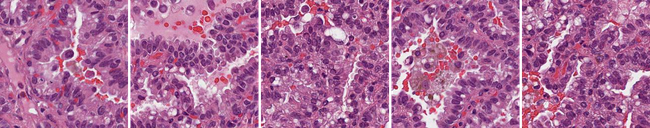

Top-k LUSC-like test samples to LUSC prototype


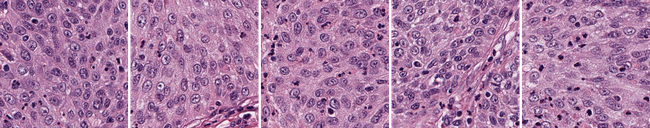

In [12]:
dist, topk_inds = proto_clf._get_topk_queries_inds(test_feats, topk=5)
print('label2idx correspondenes', train_dataset.class_to_idx)
test_imgs_df = pd.DataFrame(test_dataset.imgs, columns=['path', 'label'])

print('Top-k LUAD-like test samples to LUAD prototype')
luad_topk_inds = topk_inds[0]
luad_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][luad_topk_inds]], scale=0.5, gap=5)
display(luad_topk_imgs)

print('Top-k LUSC-like test samples to LUSC prototype')
lusc_topk_inds = topk_inds[1]
lusc_topk_imgs = concat_images([Image.open(
    img_fpath) for img_fpath in test_imgs_df['path'][lusc_topk_inds]], scale=0.5, gap=5)
display(lusc_topk_imgs)

Using `proto_clf._get_topk_prototypes_inds`, we can instead use the prototypes as the query set, and get the top-k queries to each test sample. With k set to # of prototypes / labels, we are essentially doing ROI classification (assigning label of the nearest prototype to the test sample).

In [11]:
dist, topk_inds = proto_clf._get_topk_prototypes_inds(test_feats, topk=2)
print("The top-2 closest prototypes to each test sample, with closer prototypes first (left hand side)")
display(topk_inds)

print('Labels of the top-1 closest prototypes')
pred_test = topk_inds[:, 0]

The top-2 closest prototypes to each test sample, with closer prototypes first (left hand side)


array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

Labels of the top-1 closest prototypes
